# Steam Marketplace Sentiment Prediction

Matt Calcaterra<br>
Mohammad Awad<br>

## Purpose
The intent of this project was to conduct an exploration of data and reviews for games in the Steam marketplace. After our exploration has been completed, we will attempt to build a model which can predict the sentiment of customers towards a new game which will be released. 


## Data acquisition
Our data comes from two main sources: webscraping steam reviews and the steamspy API for game information

Since both of these datasets are rather larger (specifically the reviews dataframe), they were collected in a different notebook and then saved to a csv file.

### Steamspy API

### Steam Reviews

## Import Packages

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Import statsmodels for regression
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Import scikit-learn tools for preprocessing and models
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
)
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

# Import NLTK tools for sentiment analysis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("all")

import warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

## Set up formatting for visuals

In [187]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

## Import Data

In [188]:
# reviews_df = pd.read_csv('data/steam_review_data1.csv.gz', compression='gzip')

In [189]:
sent_df = pd.read_csv("data/steam_review_sentiment.csv.gz", compression="gzip")

In [190]:
games_df = pd.read_csv("data/steamspy_data.csv")

In [191]:
games_df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags
0,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,178,196,128,999.0,999.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3..."
1,20,Team Fortress Classic,Valve,Valve,NaN,5412,895,0,"5,000,000 .. 10,000,000",551,58,14,58,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257..."
2,30,Day of Defeat,Valve,Valve,NaN,5003,556,0,"5,000,000 .. 10,000,000",421,73,23,73,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer..."
3,40,Deathmatch Classic,Valve,Valve,NaN,1852,412,0,"5,000,000 .. 10,000,000",318,0,7,0,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M..."
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,13262,662,0,"5,000,000 .. 10,000,000",676,0,150,0,499.0,499.0,0.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S..."


## Sentiment analysis

We will run sentiment analysis to access sentiment components for each review. Due to the size of our reviews dataset the sentiment analysis writes to a .csv file. This file will be used for further analysis and the code below has been commented out.

In [192]:
# def preprocess_text(text):
#     # Tokenize the text
#     tokens = word_tokenize(text.lower())

#     # Remove stop words
#     filtered_tokens = [
#         token for token in tokens if token not in stopwords.words("english")
#     ]

#     # Lemmatize the tokens
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [
#         lemmatizer.lemmatize(token) for token in filtered_tokens
#     ]

#     # Join the tokens back into a string
#     processed_text = " ".join(lemmatized_tokens)
#     return processed_text

In [193]:
# # initialize NLTK sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()


# # create get_sentiment function
# def get_sentiment(text):
#     # get sentiment scores for the review text
#     scores = analyzer.polarity_scores(text)

#     return scores

We have created two functions which we will use to extract the sentiment values from each review in our reviews dataframe. The first functinon, preprocess_text, will clean the text of each review by removing punctuation, stop words, and converting all text to lowercase. The second function, sentiment_analysis, will run sentiment analysis on each review and return the sentiment components for each review.

The sentiment analysis components will be a dictionary containing positive, negative, neutral, and compound values for each review. The compound value is a normalized value between -1 and 1 which represents the overall sentiment of the review. A compound value of 1 represents a very positive review while a compound value of -1 represents a very negative review.

In [194]:
# review_df = review_df.dropna()

In [195]:
# review_df["review_processed"] = review_df["review"].apply(preprocess_text)
# review_df["sentiment"] = review_df["review_processed"].apply(get_sentiment)

In [196]:
# reduced_df = review_df[["appid", "sentiment"]]
# reduced_df.to_csv(
#     "data/steam_review_sentiment.csv.gz", index=False, compression="gzip"
# )

Due to the size of our dataset and the caliber of computing required, the results were written to csv and used for the remainder of the analysis.

### Reformatting
Our sentiment dataframe has a dictionary of sentiment scores for each review. The issue is that it is imported as a string, so we need to convert it to a dictionary.

In [197]:
sent_df["sentiment"]

0          {'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'comp...
1          {'neg': 0.051, 'neu': 0.718, 'pos': 0.231, 'co...
2          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3          {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...
4          {'neg': 0.015, 'neu': 0.607, 'pos': 0.378, 'co...
                                 ...                        
1336150    {'neg': 0.0, 'neu': 0.268, 'pos': 0.732, 'comp...
1336151    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1336152    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1336153    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1336154    {'neg': 0.119, 'neu': 0.361, 'pos': 0.521, 'co...
Name: sentiment, Length: 1336155, dtype: object

We will run a functions which swaps single quotes for double quotes, and then converts the string to a dictionary using json.loads.

In [198]:
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", '"')
    return json.loads(dict_string)

In [199]:
sent_df["sentiment"] = sent_df["sentiment"].apply(string_to_dict)

In [200]:
# Use json normalize to write the dict to a dataframe
expanded = pd.json_normalize(sent_df["sentiment"])

In [201]:
# Concat the sentiment back onto the sentiment df with appids
sent_df = pd.concat([sent_df, expanded], axis=1)

In [202]:
# Drop the original sentiment column
sent_df = sent_df.drop(columns=["sentiment"])
sent_df.head()

,appid,neg,neu,pos,compound
0,10,0.000,0.312,0.688,0.7650
1,10,0.051,0.718,0.231,0.8519
2,10,0.000,1.000,0.000,0.0000
3,10,0.756,0.244,0.000,-0.4767
4,10,0.015,0.607,0.378,0.9769


In [203]:
# Group by average per game
sent_df = sent_df.groupby("appid").mean().reset_index()
sent_df.head()

,appid,neg,neu,pos,compound
0,10,0.10401,0.63499,0.26102,0.314473
1,20,0.08666,0.64698,0.23637,0.194547
2,30,0.12435,0.59344,0.25220,0.292516
3,40,0.12416,0.56693,0.28885,0.367227
4,50,0.07766,0.66268,0.23963,0.377009


In [204]:
sent_df = sent_df.rename(
    {
        "compound": "compound_sent",
        "neg": "neg_sent",
        "neu": "neu_sent",
        "pos": "pos_sent",
    },
    axis=1,
)

Now that we have renamed the columns we can merge is back into our game dataframe

In [205]:
games_df = pd.merge(games_df, sent_df, on="appid")

In [206]:
games_df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,...,initialprice,discount,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent
0,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,999.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3...",0.10401,0.63499,0.26102,0.314473
1,20,Team Fortress Classic,Valve,Valve,NaN,5412,895,0,"5,000,000 .. 10,000,000",551,...,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257...",0.08666,0.64698,0.23637,0.194547
2,30,Day of Defeat,Valve,Valve,NaN,5003,556,0,"5,000,000 .. 10,000,000",421,...,499.0,0.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer...",0.12435,0.59344,0.25220,0.292516
3,40,Deathmatch Classic,Valve,Valve,NaN,1852,412,0,"5,000,000 .. 10,000,000",318,...,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M...",0.12416,0.56693,0.28885,0.367227
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,13262,662,0,"5,000,000 .. 10,000,000",676,...,499.0,0.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S...",0.07766,0.66268,0.23963,0.377009


# Addressing Null Values

## Steam Game Data

In [207]:
games_df[["positive", "negative"]].isna().sum()

positive    0
negative    0
dtype: int64

There are no null values in the positive and negative review counts, so we will create a new variable: `n_reviews` and then reduce our dataset to only those with more than 100 reviews.

Since there is little data for those with less than 100 reviews we will drop those rows in favor of a more robust dataset.

We want to drop the rows at this stage because it will make it easier to fill in the null values.

In [208]:
# Create a new variable for number of reviews
games_df["n_reviews"] = games_df["positive"] + games_df["negative"]

In [209]:
# Filter out games with less than 100 reviews
games_df = games_df[games_df["n_reviews"] >= 100]

In [210]:
games_df.isna().sum()

appid                  0
name                   1
developer             50
publisher             31
score_rank         14624
positive               0
negative               0
userscore              0
owners                 0
average_forever        0
average_2weeks         0
median_forever         0
median_2weeks          0
price                  2
initialprice           1
discount               1
languages              6
genre                 69
ccu                    0
tags                   0
neg_sent               0
neu_sent               0
pos_sent               0
compound_sent          0
n_reviews              0
dtype: int64

### Price

We will assume that if the price is null, then the game is free. We will fill in the null values with 0.

In [211]:
# Assume that games with no price are free
games_df[["price", "initialprice"]] = games_df[
    ["price", "initialprice"]
].fillna(0)

### Score_rank, userscore,  and discount

In [212]:
games_df.score_rank.value_counts()

score_rank
99.0     8
100.0    5
98.0     4
97.0     1
Name: count, dtype: int64

In [213]:
games_df.userscore.value_counts()

userscore
0     14624
95        3
77        2
62        1
82        1
83        1
81        1
67        1
74        1
97        1
66        1
46        1
98        1
73        1
65        1
84        1
Name: count, dtype: int64

Since score_rank is mostly null values we are going to drop this column from our dataframe. We will also drop the userscore column since it is mostly 0 values, and will use the positive and negative review counts as our measure of popularity.

In [214]:
games_df = games_df.drop(columns=["score_rank", "userscore", "discount"])

In [215]:
games_df.head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,initialprice,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews
0,10,Counter-Strike,Valve,Valve,193046,4940,"10,000,000 .. 20,000,000",8486,178,196,...,999.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3...",0.10401,0.63499,0.26102,0.314473,197986
1,20,Team Fortress Classic,Valve,Valve,5412,895,"5,000,000 .. 10,000,000",551,58,14,...,499.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257...",0.08666,0.64698,0.23637,0.194547,6307
2,30,Day of Defeat,Valve,Valve,5003,556,"5,000,000 .. 10,000,000",421,73,23,...,499.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer...",0.12435,0.59344,0.25220,0.292516,5559
3,40,Deathmatch Classic,Valve,Valve,1852,412,"5,000,000 .. 10,000,000",318,0,7,...,499.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M...",0.12416,0.56693,0.28885,0.367227,2264
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,13262,662,"5,000,000 .. 10,000,000",676,0,150,...,499.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S...",0.07766,0.66268,0.23963,0.377009,13924


### Genre

There are 69 games in our dataset which have null values for the genre. We will fill these rows with a temporary value of 'No Genre' so that we can easily identify them. We will then decide to drop these rows after we have analysed the genre data.

In [216]:
games_df["genre"] = games_df["genre"].fillna("No Genre")

### Developer and Publisher

Simlar to genre we will fill in the null values with a temporary value of 'Unknown' so that we can easily identify them. We will then decide to drop these rows after we have analysed the developer and publisher data.

In [217]:
games_df[["developer", "publisher"]] = games_df[
    ["developer", "publisher"]
].fillna("Unknown")

### Languages



In [218]:
games_df[games_df["languages"].isna()]

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,initialprice,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews
960,106000,The Cursed Crusade,Unknown,Unknown,195,111,"0 .. 20,000",449,0,449,...,0.0,NaN,No Genre,3,"{'Action': 32, 'Adventure': 32, 'Medieval': 12...",0.20540,0.54155,0.24304,0.046420,306
1178,211050,Battle vs Chess,Unknown,Unknown,695,281,"0 .. 20,000",334,0,359,...,0.0,NaN,No Genre,27,"{'Strategy': 400, 'Chess': 56, 'Casual': 46, '...",0.12198,0.54999,0.31804,0.290660,976
2380,280620,Fiesta Online,Unknown,Unknown,236,189,"0 .. 20,000",19,0,19,...,0.0,NaN,No Genre,7,"{'Free to Play': 90, 'Anime': 67, 'Massively M...",0.12790,0.61552,0.25658,0.424404,425
2552,288570,Wolfenstein: The New Order German Edition,Unknown,Unknown,1077,195,"0 .. 20,000",755,0,831,...,0.0,NaN,No Genre,90,"{'Action': 87, 'Shooter': 40, 'FPS': 27, 'Sing...",0.15513,0.60049,0.24435,0.305095,1272
3957,354830,Wolfenstein: The Old Blood German Edition,Unknown,Unknown,485,73,"0 .. 20,000",401,0,595,...,0.0,NaN,No Genre,40,"{'Action': 38, 'Shooter': 21, 'Singleplayer': ...",0.13615,0.63503,0.22885,0.409064,558
8190,650500,Wolfenstein II: The New Colossus German Edition,Unknown,Unknown,755,336,"0 .. 20,000",880,0,1393,...,0.0,NaN,No Genre,135,"{'Action': 41, 'Violent': 35, 'Gore': 32, 'Nud...",0.21175,0.59396,0.19429,0.105363,1091


Since there are only 6 rows which have no language we will drop these rows

In [219]:
games_df = games_df[games_df["languages"].notna()]

In [220]:
games_df.isna().sum()

appid              0
name               1
developer          0
publisher          0
positive           0
negative           0
owners             0
average_forever    0
average_2weeks     0
median_forever     0
median_2weeks      0
price              0
initialprice       0
languages          0
genre              0
ccu                0
tags               0
neg_sent           0
neu_sent           0
pos_sent           0
compound_sent      0
n_reviews          0
dtype: int64

### Name

There is currently one game which has a null value for `name`. We will fill this value based on the `appid` of the game, when searched on the steam store. 

The name variable is also not very useful for our analysis and may be dropped later in favor of appid.

In [221]:
games_df[games_df["name"].isna()]

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,initialprice,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews
7355,576960,NaN,Nuclear Tales,Unknown,110,26,"20,000 .. 50,000",0,0,0,...,1499.0,"English, Spanish - Spain, French, German","Adventure, Casual, Indie, RPG, Simulation, Str...",1,"{'Adventure': 377, 'Choose Your Own Adventure'...",0.100583,0.566726,0.332595,0.494829,136


In [222]:
games_df["name"] = games_df["name"].fillna("🧠 OUT OF THE BO")

# Feature Engineering

In [223]:
games_df["percentage_positive"] = games_df["positive"] / games_df["n_reviews"]
games_df["percentage_negative"] = games_df["negative"] / games_df["n_reviews"]
games_df["review_ratio"] = games_df["positive"] / games_df["negative"]

In [224]:
games_df["percentage_positive"].describe()

count    14636.000000
mean         0.785671
std          0.154908
min          0.076923
25%          0.705518
50%          0.822745
75%          0.904523
max          1.000000
Name: percentage_positive, dtype: float64

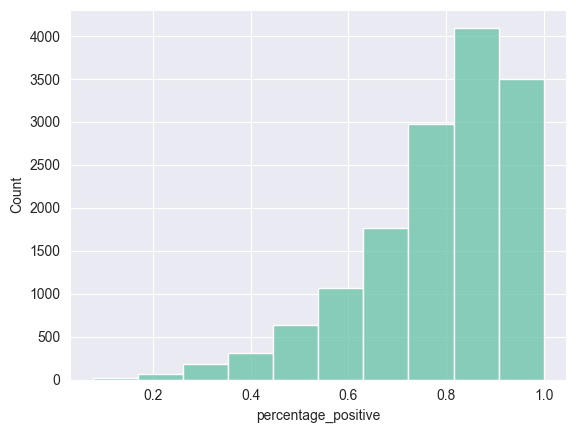

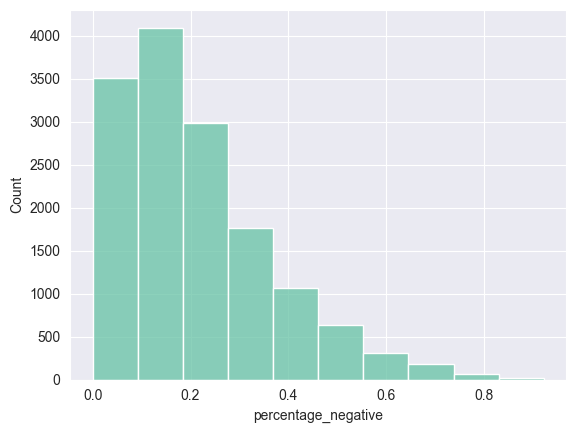

In [225]:
variables = ["percentage_positive", "percentage_negative"]

for var in variables:
    sns.histplot(games_df[var], bins=10)
    plt.show()

<Axes: xlabel='review_ratio', ylabel='Count'>

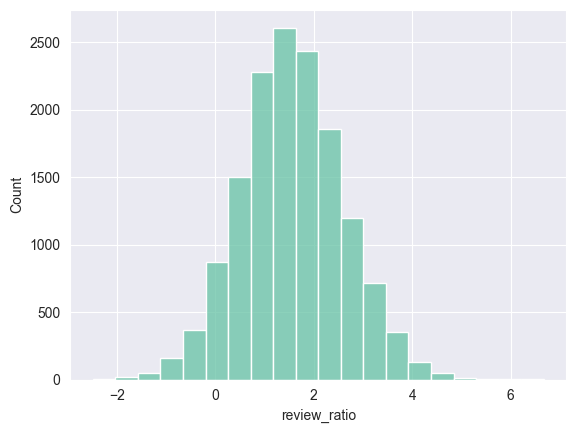

In [226]:
sns.histplot(np.log(games_df["review_ratio"]), bins=20)

<Axes: xlabel='n_reviews', ylabel='Count'>

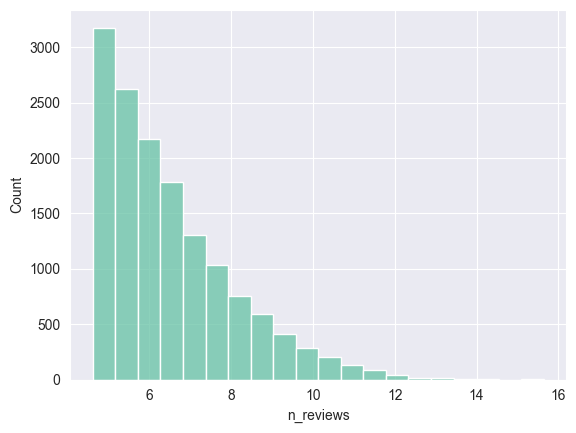

In [227]:
sns.histplot(np.log(games_df["n_reviews"]), bins=20)

Lets see how the percent positive correlates with the positive sentiment analysis score

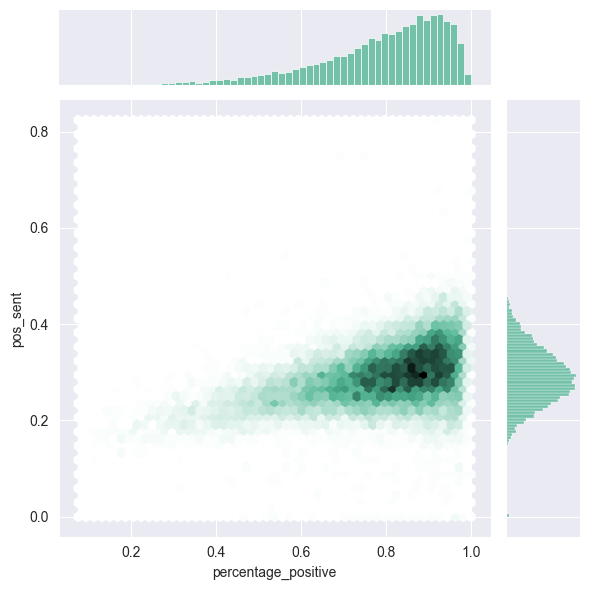

In [266]:
sns.jointplot(
    x="percentage_positive",
    y="pos_sent",
    data=games_df,
    kind="hex",
    color="#4CB391",
)
plt.show()

In [265]:
#  Use statsmodels to Create a regression model for percentage positive reviews and positive sentiment
model = ols(
    "percentage_positive ~ pos_sent", data=games_df
).fit()  # Use ordinary least squares regression

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     percentage_positive   R-squared:                       0.177
Model:                             OLS   Adj. R-squared:                  0.177
Method:                  Least Squares   F-statistic:                     3144.
Date:                 Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                         21:42:39   Log-Likelihood:                 7952.2
No. Observations:                14636   AIC:                        -1.590e+04
Df Residuals:                    14634   BIC:                        -1.589e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4792      0.006     85.746      0.000       0.468       0.490
pos_sent       1.0525      0.019     56.073      0.000       1.016       1.089
==============================================================================
Omnibus:                     1115.401   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1454.614
Skew:                          -0.679   Prob(JB):                         0.00
Kurtosis:                       3.737   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Genre Encoding

To look at the genre distributions of the games on steam, we will need to encode the genre column.<br>

Currently the genre column is a list of genres, we will split this list apart and the create a new column for each genre. If the game has that genre, then the value will be 1, otherwise it will be 0.

In [228]:
# Select appid , name, and genre columns
genre_df = games_df[
    [
        "appid",
        "name",
        "genre",
    ]
]
# Encode the genre column with dummies
genres_encoded = genre_df["genre"].str.get_dummies(sep=", ")

# Concatenate the original dataframe and the encoded genres
genres_df = pd.concat([genre_df, genres_encoded], axis=1)
genres_df.head()

,appid,name,genre,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,...,RPG,Racing,Sexual Content,Simulation,Software Training,Sports,Strategy,Utilities,Violent,Web Publishing
0,10,Counter-Strike,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Some genres only have a few games, so we will drop those genres from our dataset.

In [229]:
# Get a count of all the genres
genre_counts = genres_encoded.sum()

# Limit it to genres with less than 10 games
drop_genres = genre_counts[genre_counts < 10].index


# Update the dataframe with only the selected genres
# Also drop original genre column
genres_df.drop(drop_genres, axis=1, inplace=True)
genres_df.drop("genre", axis=1, inplace=True)

In [230]:
genres_df.head()

,appid,name,Action,Adventure,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,No Genre,RPG,Racing,Simulation,Sports,Strategy
0,10,Counter-Strike,1,0,0,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1,0,0,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,1,0,0,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,1,0,0,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1,0,0,0,0,0,0,0,0,0,0,0,0


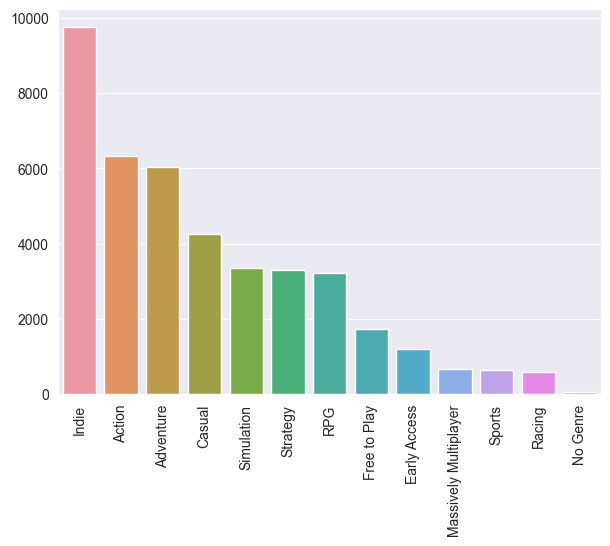

In [231]:
plt.figure(figsize=(7, 5))
sns.barplot(
    x=genres_df.drop(["appid", "name"], axis=1).columns,
    y=genres_df.drop(["appid", "name"], axis=1).sum(),
    order=genres_df.drop(["appid", "name"], axis=1)
    .sum()
    .sort_values(ascending=False)
    .index,
)
plt.xticks(rotation=90)
plt.show()

Free to play is an interesting column since indicating Free to Play as a genre does not nessecarily indicate that the price of the game is 0. We will remove Free to Play from games which are not free, and add Free to Play to those that are.

Our assumption based off the data is that adding free to play as a genre for your game listing is not required if the game is free, and can be applied even if the game is not free.

In [232]:
# get a list of all appids that are not free
not_free_games = games_df[games_df["price"] > 0]["appid"].to_list()

# set all free games to 1 and not free games to 0
genres_df[genres_df["appid"].isin(not_free_games)]["Free to Play"] = 0
genres_df[~genres_df["appid"].isin(not_free_games)]["Free to Play"] = 1

## Language Encoding

Similar to the genre column, the language column is a list of languages. Intially our intention was to follow the same procedure as we did with genre, however upon analyzing the data we found that some games had 29 different languages listed. This would result in 19 new columns for our dataset, which could cause issues with our analysis moving forward. 

Instead we will create a new column which will be the number of languages the game supports. This will allow us to see if there is a correlation between the number of languages supported and the number of positive reviews.

In [233]:
games_df["n_languages"] = games_df["languages"].str.split(",").str.len()
games_df.sort_values(by="n_languages", ascending=False).head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews,percentage_positive,percentage_negative,review_ratio,n_languages
13162,1285000,Stayhome Simulator,Two Inc,Click Games,100,30,"20,000 .. 50,000",0,0,0,...,"{'Casual': 119, 'Indie': 118, 'Action': 116, '...",0.081627,0.603569,0.275569,0.259290,130,0.769231,0.230769,3.333333,29
14313,1554790,Coloring Game 4,L. Stotch,L. Stotch,1236,77,"100,000 .. 200,000",118,0,171,...,"{'Free to Play': 35, 'Indie': 34, 'Casual': 34...",0.060900,0.539490,0.389620,0.533057,1313,0.941356,0.058644,16.051948,29
10666,939390,The Life of One Dog,BrainStorming Team,КиКо,46,60,"0 .. 20,000",0,0,0,...,"{'Casual': 24, 'RPGMaker': 8}",0.211256,0.595721,0.169651,-0.121077,106,0.433962,0.566038,0.766667,29
13230,1295790,The Longest Road on Earth,"Brainwash Gang, TLR Games",Raw Fury,215,32,"0 .. 20,000",0,0,0,...,"{'Adventure': 268, 'Casual': 258, 'Interactive...",0.068750,0.664610,0.266660,0.551253,247,0.870445,0.129555,6.718750,29
11601,1064730,Fantasy Girl,Inverse Game,Inverse Game,4723,227,"100,000 .. 200,000",17,0,21,...,"{'Sexual Content': 122, 'Nudity': 101, 'Mature...",0.107160,0.610710,0.282090,0.335418,4950,0.954141,0.045859,20.806167,29


<Axes: xlabel='n_languages', ylabel='Count'>

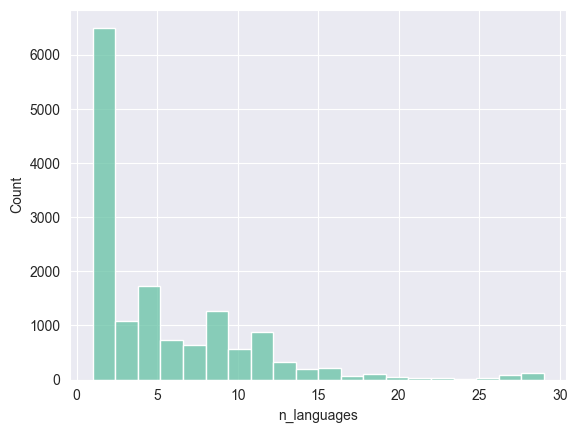

In [234]:
sns.histplot(games_df["n_languages"], bins=20)

**Note:** insights from graphs

In [235]:
games_df[games_df["n_languages"] == 1].value_counts("languages")

languages
English                5044
Simplified Chinese       36
Japanese                  5
Russian                   2
French                    1
Korean                    1
Thai                      1
Traditional Chinese       1
Name: count, dtype: int64

Looking at games which only have 1 language listed, English was by far the most common language, followed by Simplified Chinese, Japenese, and Russian.

# Model  Building

## Feature Selection

In [236]:
# Select features and target
features = [
    "developer",
    "publisher",
    "genre",
    "price",
    "n_languages",
]  # Add 'categories' if available
X = games_df[features]
y = games_df["percentage_positive"]

In [237]:
# create a second variable as the sentiment of the games which could potentially be more accurate
y2 = games_df["compound_sent"]

We will be creating a regression model to predict the consumer sentiment of a new game entering the marketplace. We will be using the following features:
- developer
- publisher
- genre
- price
- n_languages

We will compare two models one predicting the percentage of positive ratings as indicated by Steam, and the composite sentiment score as determined by our sentiment analysis.

These features were chosen as they will be known before the game is released, and are not dependent on the popularity of the game.

## Test and Train Sets

We will use a 80-20 split for our test and train sets. We will also use a random state of 42 to ensure that our results are reproducible.

80% of our original data wil be used for training, and 20% will be used for testing.

In [238]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X, y2, test_size=0.2, random_state=42
)

## Model Pipeline

### Preprocessing

Our preprocessing pipeline will consist of the following steps:
- OneHotEncoding for developer and publisher
- StandardScaler for price and n_languages

In [239]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["price", "n_languages"]),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            ["developer", "publisher", "genre"],
        ),
    ]
)

In [240]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Model Selection

We will start with three models:
- Linear Regression
- Random Forest Regressor
- Support Vector Regressor

And a voting regressor which will use all three models.

The performance of each model will be evaluated using the root mean square error

In [241]:
# Establish our regressors
reg1 = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
reg2 = LinearRegression()
reg3 = SVR(kernel="rbf")

In [242]:
# Model pipeline
pipe1 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rf", reg1),
    ]
)

In [243]:
pipe2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("lr", reg2),
    ]
)

In [244]:
pipe3 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("svr", reg3),
    ]
)

### Hyperparameter Tuning

In [245]:
# Hyperparameter tuning grid
param_grid = {
    "rf": {"n_estimators": [10, 20, 30], "max_depth": [None, 5, 10]},
    "svr": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf", "poly"]},
    "lr": {
        "fit_intercept": [True, False],
    },
}

In [246]:
models = {"rf": reg1, "lr": reg2, "svr": reg3}

best_params = {}
# Use our param grid and GridSearchCV to find the best parameters.
for name, model in models.items():
    grid = GridSearchCV(model, param_grid[name], cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train_prep, y_train)
    best_params[name] = grid.best_params_
    print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 10, 'n_estimators': 30}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'fit_intercept': True}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 0.1, 'kernel': 'linear'}


In [247]:
# set the parameters for our models to the best parameters
reg1.set_params(**best_params["rf"])
reg2.set_params(**best_params["lr"])
reg3.set_params(**best_params["svr"])

SVR(C=0.1, kernel='linear')

The hyperparameters for each model will be tuned using a grid search with 5-fold cross validation.

The resulting hyperparameters will be used to create a new model, which will be used for our final predictions.

### Random Forest Regressor

In [248]:
pipe1.fit(X_train, y_train)

y_pred = pipe1.predict(X_test)

print(
    "Random Forest Regressor Mean Squared Error:",
    mean_squared_error(y_test, y_pred),
)

Random Forest Regressor Mean Squared Error: 0.021704423869574475


In [249]:
pipe1.fit(X2_train, y2_train)

y2_pred = pipe1.predict(X2_test)

print(
    "Random Forest Regressor Mean Squared Error:",
    mean_squared_error(y2_test, y2_pred),
)

Random Forest Regressor Mean Squared Error: 0.03543824411221506


### Linear Regression

In [250]:
pipe2.fit(X_train, y_train)

y_pred = pipe2.predict(X_test)

print(
    "Linear Regression Mean Squared Error:", mean_squared_error(y_test, y_pred)
)

Linear Regression Mean Squared Error: 0.027297662272527987


In [251]:
pipe2.fit(X2_train, y2_train)

y2_pred = pipe2.predict(X2_test)

print(
    "Random Forest Regressor Mean Squared Error:",
    mean_squared_error(y2_test, y2_pred),
)

Random Forest Regressor Mean Squared Error: 0.04379990206607815


### Support Vector Regressor

In [252]:
pipe3.fit(X_train, y_train)

y_pred = pipe3.predict(X_test)

print("SVR Mean Squared Error:", mean_squared_error(y_test, y_pred))

SVR Mean Squared Error: 0.019498451037983037


In [253]:
pipe3.fit(X2_train, y2_train)

y2_pred = pipe3.predict(X2_test)

print(
    "Random Forest Regressor Mean Squared Error:",
    mean_squared_error(y2_test, y2_pred),
)

Random Forest Regressor Mean Squared Error: 0.03121813056539592


### Voting Regressor

Once we have determined our best hyperparameters, we will use a voting regressor to combine the results of our three models.

In [254]:
# Establish a voting regressor with the best parameters from each model
voting_reg = VotingRegressor(
    [("rf", reg1), ("lr", reg2), ("svr", reg3)], n_jobs=-1
)

In [255]:
pipe4 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("voting", voting_reg),
    ]
)

In [256]:
pipe4.fit(X_train, y_train)

y_pred = pipe4.predict(X_test)

print(
    "Voting Regressor Mean Squared Error:", mean_squared_error(y_test, y_pred)
)

Voting Regressor Mean Squared Error: 0.01985230573206011


In [257]:
pipe4.fit(X2_train, y2_train)

y2_pred = pipe4.predict(X2_test)

print(
    "Random Forest Regressor Mean Squared Error:",
    mean_squared_error(y2_test, y2_pred),
)

Random Forest Regressor Mean Squared Error: 0.03200390507690795


Based on our evaluation of each model we have decided to go with the voting regressor as our final model. The voting regressor will use the results of our three models to make a prediction.

## Final Model Predictions

In [258]:
voting_reg.fit(X_train_prep, y_train)

y_pred = voting_reg.predict(X_test_prep)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.01985230573206011


---